In [29]:
#pip install pandas_datareader
#pip install yfinance

In [30]:
import numpy as np

import pandas_datareader as web
import yfinance as yfin
yfin.pdr_override()

import pandas as pd
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)
plt.style.use('fivethirtyeight') 

#import pypfopt

In [31]:
#defining time range
from datetime import datetime, timedelta
start_date =  datetime.today() - timedelta(days=365) #Last 365 days
end_date = datetime.today()
#print(start, end)

symbols = ["XLC", "XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLK", "XLRE", "XLU", "SPY", "BIL"] #"SPY", "BIL" MUST be final 2 symbols

stock_data = web.get_data_yahoo(symbols, start= start_date, end= end_date)

In [32]:
#print(stock_data)

pct_returns_df = stock_data["Adj Close"].pct_change().apply(lambda x: np.log(1+x))
pct_returns_df.dropna(inplace= True)
#print(pct_returns_df)

excess_returns_df = pct_returns_df.sub(pct_returns_df['BIL'], axis= 0)
print(excess_returns_df)

Symbols          XLC       XLY       XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE       XLU       SPY  BIL
Date                                                                                                                                   
2021-08-12  0.001806  0.000439 -0.000556 -0.000999  0.001803  0.007859 -0.001897 -0.001620  0.005725  0.003452  0.001027  0.002992  0.0
2021-08-13  0.000492 -0.002969  0.008200 -0.011977 -0.007598  0.006118 -0.003247  0.000817  0.005325  0.006545  0.006904  0.001709  0.0
2021-08-16  0.001900 -0.004419  0.005994 -0.018366 -0.002377  0.011524  0.003641 -0.004768  0.004725  0.001288  0.006315  0.002571  0.0
2021-08-17 -0.008315 -0.024025  0.000548 -0.010361 -0.007041  0.011764 -0.010879 -0.011576 -0.008320  0.001922  0.000579 -0.006577  0.0
2021-08-18 -0.007653  0.003565 -0.012549 -0.021049 -0.012377 -0.015320 -0.010999 -0.011711 -0.013891 -0.010507 -0.005075 -0.011005  0.0
...              ...       ...       ...       .

         Standard Deviation  Mean Excess Return
Symbols                                        
XLC                0.016527           -0.001358
XLY                0.019400           -0.000348
XLP                0.009925            0.000245
XLE                0.020944            0.001916
XLF                0.014023           -0.000349
XLV                0.010620            0.000048
XLI                0.011931           -0.000233
XLB                0.013197           -0.000259
XLK                0.017806           -0.000126
XLRE               0.013282           -0.000035
XLU                0.010910            0.000520
SPY                0.012979           -0.000174
BIL                0.000000            0.000000


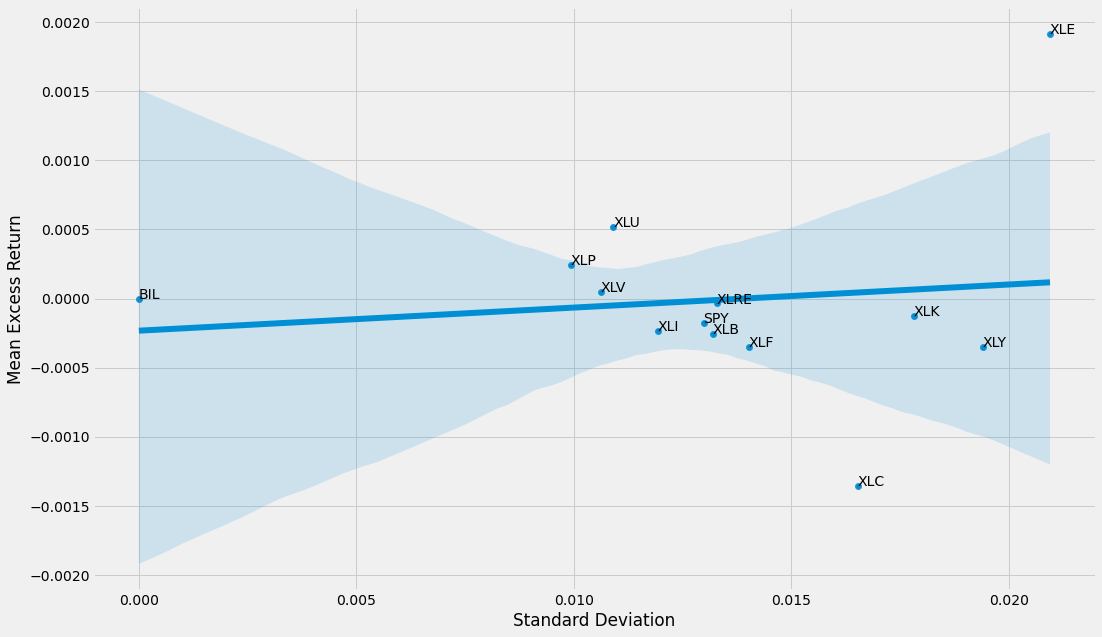

In [33]:
import seaborn as sns

excess_std_mean_df = pd.DataFrame(columns = ['Standard Deviation', 'Mean Excess Return'])
excess_std_mean_df['Standard Deviation'] = excess_returns_df.std()
excess_std_mean_df['Mean Excess Return'] = excess_returns_df.mean()
print(excess_std_mean_df)

excess_std_mean_df.plot(kind = 'scatter', x = 'Standard Deviation', y = 'Mean Excess Return')
for i, symbol in enumerate(symbols):
    plt.annotate(symbol, (excess_std_mean_df['Standard Deviation'][i], excess_std_mean_df['Mean Excess Return'][i]))

#a, b = np.polyfit(excess_std_mean_df['Standard Deviation'], excess_std_mean_df['Mean Excess Return'], 1)
#plt.plot(excess_std_mean_df['Standard Deviation'], a*excess_std_mean_df['Standard Deviation']+b, linestyle = '--', linewidth = 2)

sns.regplot(x= excess_std_mean_df['Standard Deviation'], y= excess_std_mean_df['Mean Excess Return']) #ci= 0
plt.show()

Symbols       XLC       XLY       XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE       XLU       SPY  BIL
Symbols                                                                                                                             
XLC      1.000000  0.814503  0.419292  0.251428  0.681640  0.586021  0.720974  0.690722  0.845008  0.557116  0.279064  0.869458  NaN
XLY      0.814503  1.000000  0.458336  0.267184  0.702505  0.555851  0.757912  0.690871  0.884244  0.583103  0.261000  0.900213  NaN
XLP      0.419292  0.458336  1.000000  0.198488  0.565758  0.693257  0.635070  0.594981  0.501084  0.651246  0.659134  0.628536  NaN
XLE      0.251428  0.267184  0.198488  1.000000  0.470188  0.215931  0.476215  0.491708  0.253832  0.280604  0.253635  0.387925  NaN
XLF      0.681640  0.702505  0.565758  0.470188  1.000000  0.637761  0.854360  0.828620  0.709864  0.610685  0.381225  0.837583  NaN
XLV      0.586021  0.555851  0.693257  0.215931  0.637761  1.000000  

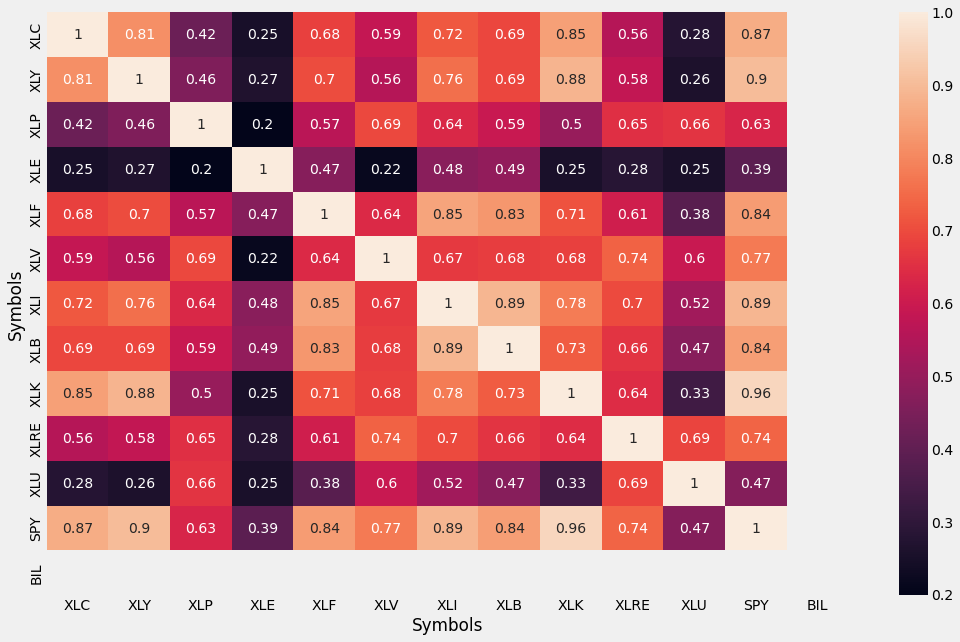

<Figure size 1152x720 with 0 Axes>

In [34]:
corr_matrix_excess = excess_returns_df.corr()
print(corr_matrix_excess)
sns.heatmap(corr_matrix_excess, annot= True)
plt.show()
plt.clf()

In [35]:
from sklearn.linear_model import LinearRegression

excess_returns_df = excess_returns_df.dropna()
betas_df = pd.DataFrame(columns= symbols)
#print(betas_df)
alphas_df = pd.DataFrame(columns= symbols)
#print(expected_returns_df)
alphas_list = []

for column in excess_returns_df:   
    x = np.array(excess_returns_df['SPY']).reshape((-1, 1))
    #print(x)

    y = np.array(excess_returns_df[column])
    #print(y)
    
    model = LinearRegression().fit(x, y)
    alphas_df[column] = pd.Series(model.intercept_)
    betas_df[column] = model.coef_
    #print(column, model.intercept_, model.coef_)
    alphas_list.append(model.intercept_)

alphas_list = alphas_list[:-2]
#print(alphas_list)
print(alphas_df)
print()
print(betas_df)

        XLC       XLY       XLP       XLE       XLF       XLV       XLI      XLB       XLK      XLRE       XLU           SPY  BIL
0 -0.001165 -0.000114  0.000329  0.002025 -0.000192  0.000158 -0.000091 -0.00011  0.000103  0.000096  0.000588  8.131516e-20  0.0

        XLC       XLY      XLP       XLE       XLF       XLV       XLI       XLB      XLK      XLRE       XLU  SPY  BIL
0  1.107107  1.345584  0.48061  0.625971  0.904932  0.634017  0.816956  0.855524  1.31138  0.755123  0.391118  1.0 -0.0


In [41]:
hedge_df = excess_returns_df.reset_index()
hedge_df = hedge_df.iloc[:,1:]
#print(hedge_df)

for col in hedge_df:
    for i, row_value in hedge_df[col].iteritems():
        hedge_df[col][i] = hedge_df[col][i] - betas_df[col]*hedge_df["SPY"][i]

hedge_df.drop(index = hedge_df.index[0], axis= 0, inplace= True)
hedge_df.drop(["SPY", "BIL"], axis= 1, inplace= True)
print(hedge_df)

Symbols       XLC       XLY       XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE       XLU
1       -0.001400 -0.005269  0.007379 -0.013047 -0.009144  0.005035 -0.004643 -0.000645  0.003084  0.005255  0.006236
2       -0.000946 -0.007877  0.004759 -0.019976 -0.004703  0.009894  0.001541 -0.006967  0.001354 -0.000653  0.005310
3       -0.001034 -0.015175  0.003709 -0.006244 -0.001090  0.015934 -0.005506 -0.005949  0.000305  0.006888  0.003151
4        0.004531  0.018373 -0.007260 -0.014160 -0.002418 -0.008343 -0.002008 -0.002296  0.000541 -0.002197 -0.000771
5       -0.001568 -0.008409  0.007159 -0.027345 -0.008868  0.003456 -0.008313 -0.010320  0.007777  0.007150  0.003324
..            ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...
247     -0.010464 -0.014845 -0.001576  0.020599  0.008659  0.000612  0.002904  0.004923 -0.000023  0.004431 -0.003102
248      0.007061  0.006094 -0.000035  0.005872  0.00044

Symbols       XLC       XLY       XLP       XLE       XLF       XLV       XLI       XLB       XLK      XLRE       XLU
Symbols                                                                                                              
XLC      0.000067  0.000010 -0.000021 -0.000030 -0.000011 -0.000015 -0.000010 -0.000009  0.000004 -0.000019 -0.000023
XLY      0.000010  0.000072 -0.000021 -0.000034 -0.000014 -0.000029 -0.000010 -0.000017  0.000008 -0.000021 -0.000034
XLP     -0.000021 -0.000021  0.000060 -0.000010  0.000005  0.000022  0.000009  0.000009 -0.000018  0.000025  0.000040
XLE     -0.000030 -0.000034 -0.000010  0.000374  0.000043 -0.000019  0.000033  0.000046 -0.000044 -0.000002  0.000017
XLF     -0.000011 -0.000014  0.000005  0.000043  0.000059 -0.000002  0.000018  0.000023 -0.000023 -0.000001 -0.000001
XLV     -0.000015 -0.000029  0.000022 -0.000019 -0.000002  0.000045 -0.000002  0.000004 -0.000011  0.000023  0.000027
XLI     -0.000010 -0.000010  0.000009  0.000033  0.00001

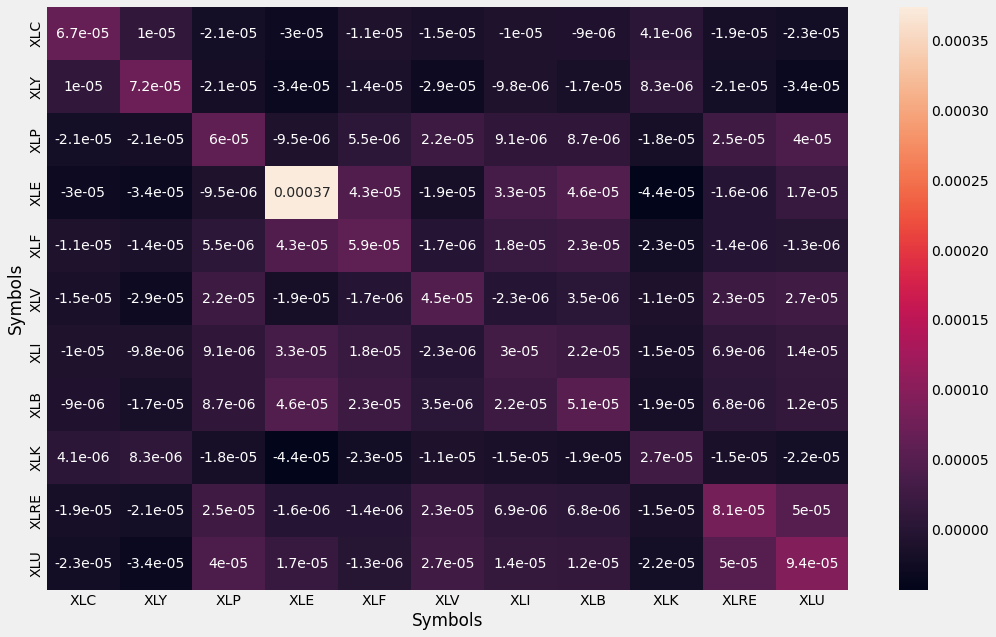


E[R]-rf
XLC    -0.001165
XLY    -0.000114
XLP     0.000329
XLE     0.002025
XLF    -0.000192
XLV     0.000158
XLI    -0.000091
XLB    -0.000110
XLK     0.000103
XLRE    0.000096
XLU     0.000588
dtype: float64


In [42]:
hedge_var_covar = hedge_df.cov()
#print("Variance - covariance matrix")
print(hedge_var_covar)
sns.heatmap(hedge_var_covar, annot= True)
plt.show()

print()
print("E[R]-rf")
print(pd.Series(alphas_list, index= symbols[:-2]))

{'XLC': -0.02857, 'XLY': 0.13301, 'XLP': 0.09206, 'XLE': 0.09201, 'XLF': 0.08286, 'XLV': 0.15409, 'XLI': 0.00678, 'XLB': 0.00111, 'XLK': 0.39503, 'XLRE': -0.01387, 'XLU': 0.08549}
Expected annual return: 0.0%
Annual volatility: 0.2%
Sharpe Ratio: 0.21


<AxesSubplot:xlabel='Weight'>

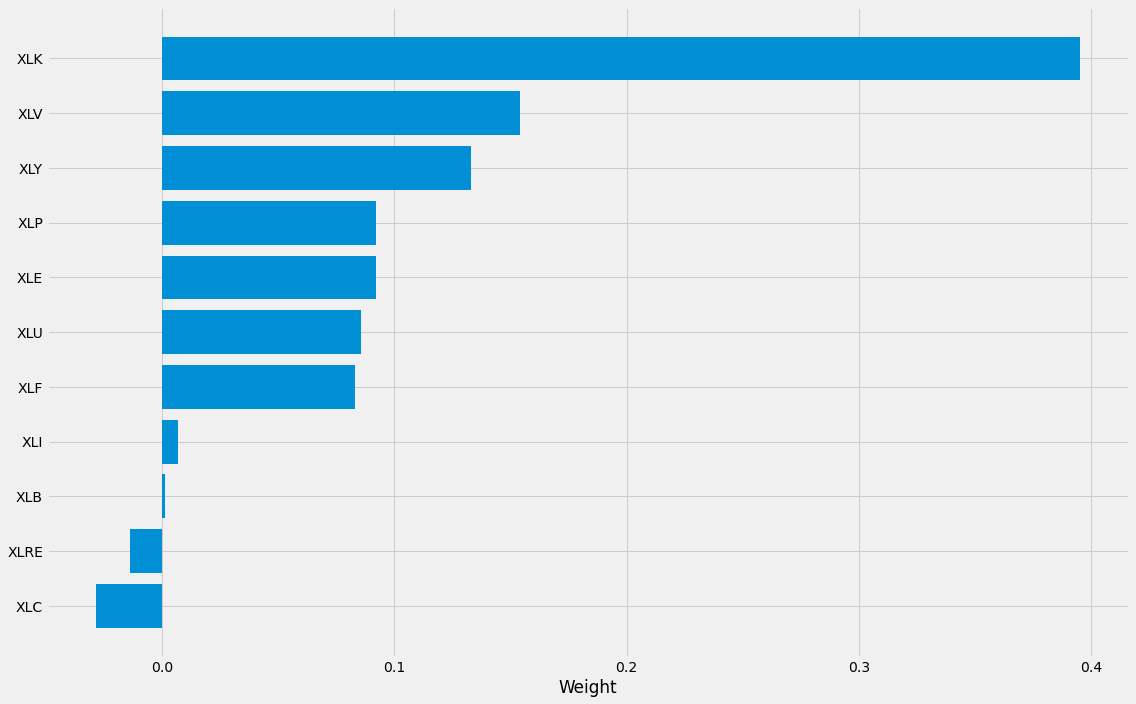

In [43]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting

#excess_returns = excess_std_mean_df["Mean Excess Return"].drop(["SPY", "BIL"])
#print(excess_returns)

ef = EfficientFrontier(alphas_list, hedge_var_covar, weight_bounds= (-0.2, 0.5), solver= 'ECOS_BB') # weight_bounds= (-1, 1)
weights = ef.max_sharpe(risk_free_rate= 0)
cleaned_weights = dict(ef.clean_weights())

print(cleaned_weights)
ef.portfolio_performance(verbose = True, risk_free_rate= 0)

plotting.plot_weights(cleaned_weights)

In [44]:
final_df = pd.DataFrame.from_dict(cleaned_weights, orient= 'index')
final_df.rename(columns= {0: "Weights"}, inplace= True)

#print(final_df)
#print(betas_df.columns)
#if "SPY" in betas_df.columns :
#betas_df.drop(["SPY", "BIL"], axis= 1, inplace= True)
#print(betas_df.values)
final_df["Beta"] = betas_df.iloc[:,:-2].values.T
final_df["Market"] = final_df["Weights"]*final_df["Beta"]*-1
final_df["BIL"] = final_df["Weights"]*(final_df["Beta"]-1)

print(final_df)

sum_market = final_df["Market"].sum()
sum_bil = final_df["BIL"].sum()
print()
print("Building a dollar neutral strategy:")
print("Sum SPY: ", sum_market, "Sum BIL: ", sum_bil)
print("Sum SPY+BIL: ", sum_market+sum_bil)



      Weights      Beta    Market       BIL
XLC  -0.02857  1.107107  0.031630 -0.003060
XLY   0.13301  1.345584 -0.178976  0.045966
XLP   0.09206  0.480610 -0.044245 -0.047815
XLE   0.09201  0.625971 -0.057596 -0.034414
XLF   0.08286  0.904932 -0.074983 -0.007877
XLV   0.15409  0.634017 -0.097696 -0.056394
XLI   0.00678  0.816956 -0.005539 -0.001241
XLB   0.00111  0.855524 -0.000950 -0.000160
XLK   0.39503  1.311380 -0.518034  0.123004
XLRE -0.01387  0.755123  0.010474  0.003396
XLU   0.08549  0.391118 -0.033437 -0.052053

Building a dollar neutral strategy:
Sum SPY:  -0.9693511589451085 Sum BIL:  -0.03064884105489158
Sum SPY+BIL:  -1.0


       Weights       $ Amount  Last Price  Number of Shares
SPY  -0.969351 -484675.579473  419.589996           -1155.1
BIL  -0.030649  -15324.420527   91.440002            -167.6
XLC  -0.028570  -14285.000000   58.540001            -244.0
XLRE -0.013870   -6935.000000   44.689999            -155.2
XLB   0.001110     555.000000   79.589996               7.0
XLI   0.006780    3390.000000   98.250000              34.5
XLF   0.082860   41430.000000   34.955002            1185.2
XLU   0.085490   42745.000000   75.519997             566.0
XLE   0.092010   46005.000000   77.669998             592.3
XLP   0.092060   46030.000000   74.785004             615.5
XLY   0.133010   66505.000000  165.910004             400.8
XLV   0.154090   77045.000000  131.729996             584.9
XLK   0.395030  197515.000000  147.595001            1338.2


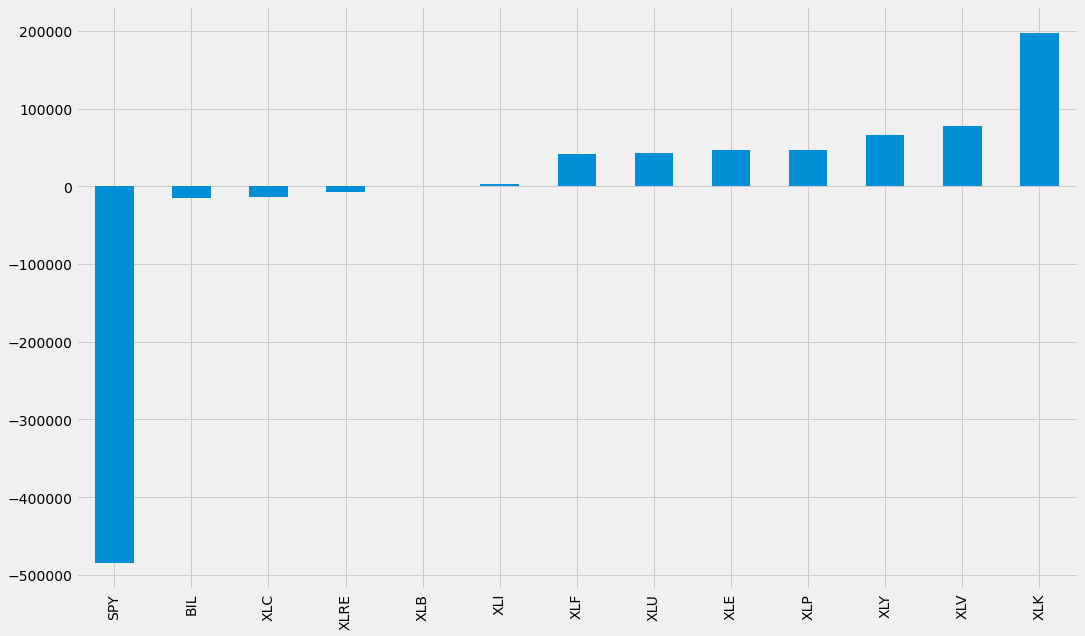

In [45]:
from pypfopt.discrete_allocation import get_latest_prices

cash_investment = 500000

hedge_weights  = cleaned_weights
hedge_weights["SPY"] = sum_market
hedge_weights["BIL"] = sum_bil

discrete_df = pd.DataFrame.from_dict(hedge_weights, orient= 'index')
discrete_df.rename(columns= {0: "Weights"}, inplace= True)
discrete_df["$ Amount"] = discrete_df["Weights"]*cash_investment
discrete_df["Last Price"] = get_latest_prices(stock_data["Adj Close"])
discrete_df["Number of Shares"] = round(discrete_df["$ Amount"]/discrete_df["Last Price"], 1)

discrete_df.sort_values(by=["$ Amount"], inplace= True)
print(discrete_df)
discrete_df["$ Amount"].plot(kind = 'bar')
plt.show()